In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('california_enrollment.csv', thousands=',')
print(df.head())

        State   Month         ManagedCareParticipation  CountEnrolled  \
0  California  201601       Comprehensive managed care       10371034   
1  California  201601     Primary care case management            836   
2  California  201601            MLTSS, including PACE           5731   
3  California  201601  Behavioral health organizations              0   
4  California  201601  Nonmedical prepaid health plans         933923   

     DQUnusable  
0           NaN  
1  Not assessed  
2  Not assessed  
3  Not assessed  
4  Not assessed  


In [3]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y%m')

df['CountEnrolled'] = pd.to_numeric(df['CountEnrolled'], errors='coerce')

df['Year'] = df['Month'].dt.year

In [4]:
# First, we calculate the total enrollment for each month.
monthly_totals = df.groupby(['Month'])['CountEnrolled'].sum().reset_index()

# Next, we'll extract the 'Year'.
monthly_totals['Year'] = pd.to_datetime(monthly_totals['Month'], format='%Y%m').dt.year

# Finally, we calculate the average of these monthly totals for the year.
average_total_enrollment = monthly_totals.groupby(['Year'])['CountEnrolled'].mean().reset_index()
average_total_enrollment

,Year,CountEnrolled
0,2016,1.160780e+07
1,2017,1.180462e+07
2,2018,1.162285e+07
3,2019,1.132289e+07
4,2020,1.153199e+07
5,2021,1.263607e+07
6,2022,1.377576e+07


20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing


Historical California Enrollment Data:
          ds          y
0 2016-01-01  11.607795
1 2017-01-01  11.804622
2 2018-01-01  11.622846
3 2019-01-01  11.322889
4 2020-01-01  11.531986
5 2021-01-01  12.636072
6 2022-01-01  13.775762

Forecast period: 2023 to 2032

California Enrollment Forecast (Millions):
    Year   yhat  yhat_lower  yhat_upper
6   2022  13.77       13.76       13.78
7   2023  14.89       14.59       15.16
8   2024  16.01       15.02       16.89
9   2025  17.13       15.21       19.09
10  2026  18.25       15.24       21.26
11  2027  19.37       15.14       23.59
12  2028  20.49       14.95       26.01
13  2029  21.62       14.51       28.47
14  2030  22.74       14.10       30.98
15  2031  23.86       13.31       33.97
16  2032  24.98       12.54       36.57


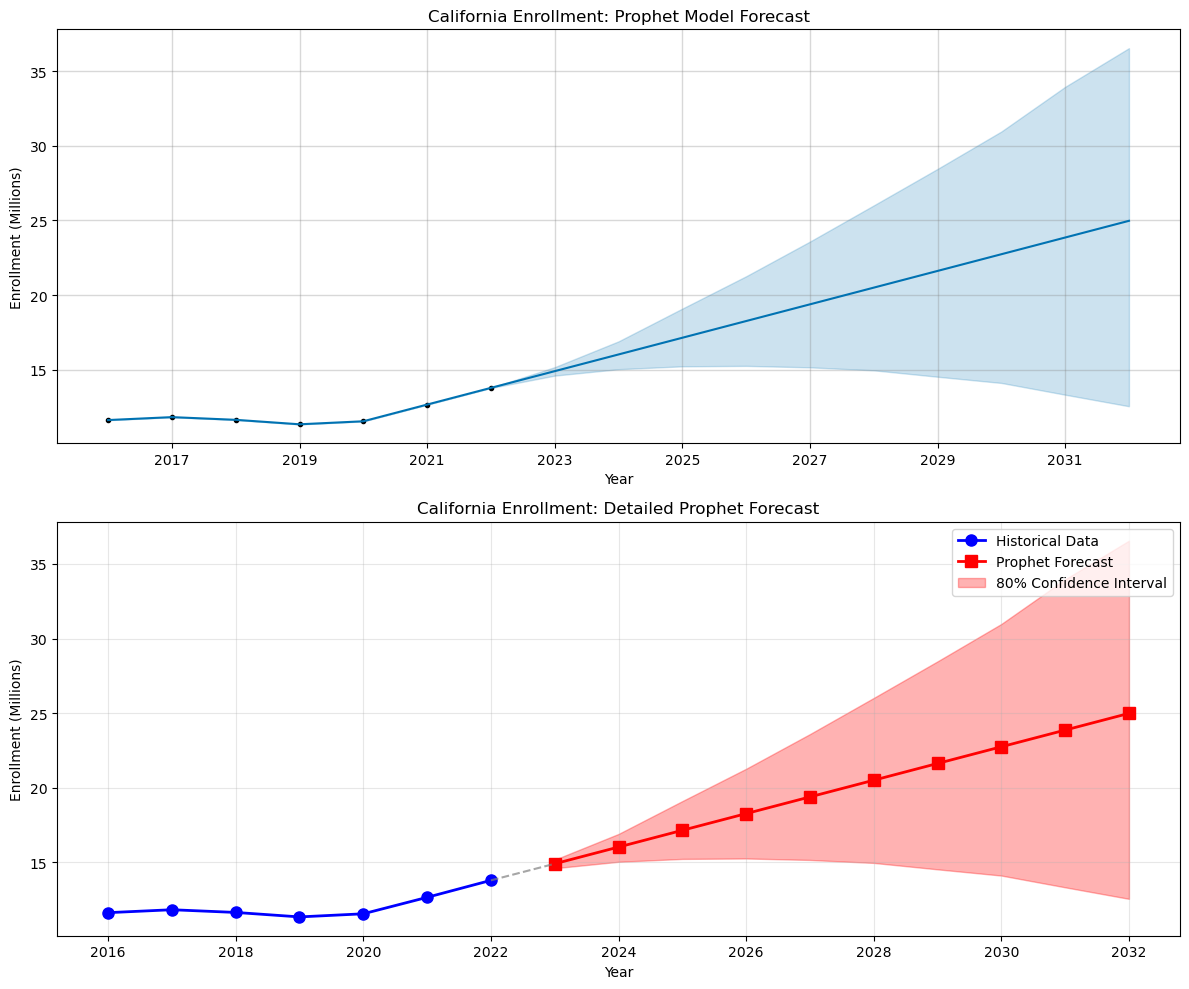


Detailed Results:
Last historical (2022): 13.78M
2032 forecast: 24.98M
2032 range: 12.54M - 36.57M

Growth Analysis:
Historical avg growth: 0.310M per year
Forecast avg growth: 1.120M per year
Total growth (2022-2032): 81.3%

Model Components:
Final trend component: 24.98M

Forecast plot saved as 'california_enrollment_prophet_forecast.png'

Model Performance on Historical Data:
Mean Absolute Error: 0.004M
Root Mean Square Error: 0.006M


<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

# Use your data
data = average_total_enrollment.copy()

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_data = pd.DataFrame({
    'ds': pd.to_datetime(data['Year'], format='%Y'),  # Convert year to datetime
    'y': data['CountEnrolled'] / 1e6  # Convert to millions for readability
})

print("Historical California Enrollment Data:")
print(prophet_data)

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=False,    # No yearly seasonality for annual data
    weekly_seasonality=False,    # No weekly seasonality
    daily_seasonality=False,     # No daily seasonality
    changepoint_prior_scale=0.1, # Control flexibility of trend changes
    interval_width=0.8           # 80% confidence intervals
)

# Fit the model
model.fit(prophet_data)

# Create future dataframe for forecasting (next 10 years)
future_years = pd.date_range(start='2023-01-01', end='2032-12-31', freq='YS')  # Year start frequency
future = model.make_future_dataframe(periods=10, freq='YS')

print(f"\nForecast period: {future_years[0].year} to {future_years[-1].year}")

# Generate forecast
forecast = model.predict(future)

# Display forecast results
forecast_display = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)  # Show last 11 (10 forecasts + 1 historical)
forecast_display['Year'] = forecast_display['ds'].dt.year
forecast_display = forecast_display[['Year', 'yhat', 'yhat_lower', 'yhat_upper']]

print("\nCalifornia Enrollment Forecast (Millions):")
print(forecast_display.round(2))

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Prophet's built-in plot
model.plot(forecast, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Enrollment (Millions)')
ax1.set_title('California Enrollment: Prophet Model Forecast')
ax1.grid(True, alpha=0.3)

# Plot 2: Custom detailed plot
years = prophet_data['ds'].dt.year
historical = prophet_data['y'].values
forecast_years = forecast['ds'].dt.year[-10:]  # Last 10 years are forecasts
forecast_values = forecast['yhat'].iloc[-10:].values
forecast_lower = forecast['yhat_lower'].iloc[-10:].values
forecast_upper = forecast['yhat_upper'].iloc[-10:].values

# Plot historical data
ax2.plot(years, historical, 'o-', label='Historical Data', 
         color='blue', linewidth=2, markersize=8)

# Plot forecast
ax2.plot(forecast_years, forecast_values, 's-', label='Prophet Forecast', 
         color='red', linewidth=2, markersize=8)

# Add confidence intervals
ax2.fill_between(forecast_years, forecast_lower, forecast_upper, 
                alpha=0.3, color='red', label='80% Confidence Interval')

# Add connecting line between last historical and first forecast
last_historical_year = years.iloc[-1]
last_historical_value = historical[-1]
first_forecast_year = forecast_years.iloc[0]
first_forecast_value = forecast_values[0]

ax2.plot([last_historical_year, first_forecast_year], 
         [last_historical_value, first_forecast_value], 
         '--', color='gray', alpha=0.7)

ax2.set_xlabel('Year')
ax2.set_ylabel('Enrollment (Millions)')
ax2.set_title('California Enrollment: Detailed Prophet Forecast')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\nDetailed Results:")
print(f"Last historical ({years.iloc[-1]}): {historical[-1]:.2f}M")
print(f"2032 forecast: {forecast_values[-1]:.2f}M")
print(f"2032 range: {forecast_lower[-1]:.2f}M - {forecast_upper[-1]:.2f}M")

# Calculate growth metrics
historical_growth = (historical[-1] - historical[0]) / len(historical)
forecast_growth = (forecast_values[-1] - historical[-1]) / 10
total_growth = ((forecast_values[-1] / historical[-1]) - 1) * 100

print(f"\nGrowth Analysis:")
print(f"Historical avg growth: {historical_growth:.3f}M per year")
print(f"Forecast avg growth: {forecast_growth:.3f}M per year")
print(f"Total growth (2022-2032): {total_growth:.1f}%")

# Prophet model components (if you want to see trend decomposition)
print(f"\nModel Components:")
components = model.predict(future)
print(f"Final trend component: {components['trend'].iloc[-1]:.2f}M")

# Save the plots
plt.savefig("california_enrollment_prophet_forecast.png", dpi=300, bbox_inches='tight')
print(f"\nForecast plot saved as 'california_enrollment_prophet_forecast.png'")

# Optional: Show model performance metrics on historical data
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions for historical period
historical_forecast = forecast[forecast['ds'].isin(prophet_data['ds'])]
mae = mean_absolute_error(prophet_data['y'], historical_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(prophet_data['y'], historical_forecast['yhat']))

print(f"\nModel Performance on Historical Data:")
print(f"Mean Absolute Error: {mae:.3f}M")
print(f"Root Mean Square Error: {rmse:.3f}M")

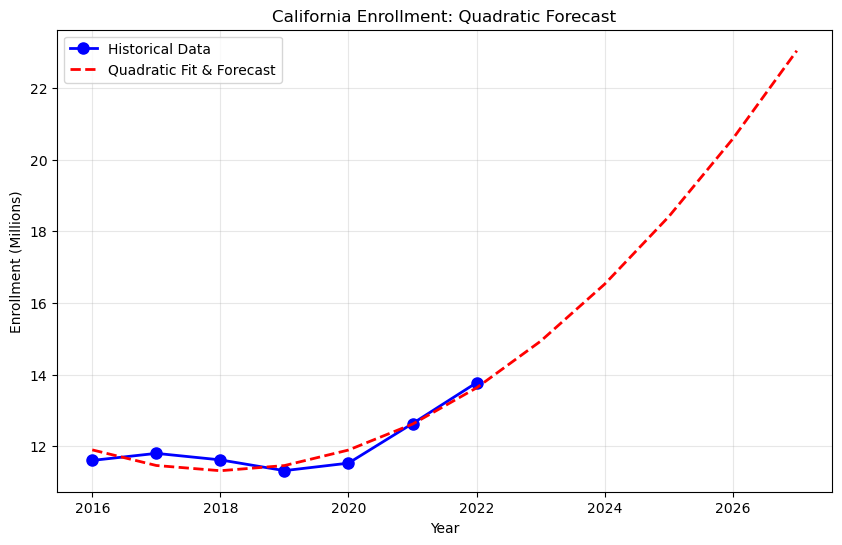

Last historical (2022): 13.78M
2027 forecast: 23.04M
Equation: y = 0.144783x² + -584.3437x + 589615.24


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Use your data
data = average_total_enrollment.copy()
years = data['Year'].values
enrollment = data['CountEnrolled'].values / 1e6  # Convert to millions

# Fit degree 2 polynomial (quadratic)
coeffs = np.polyfit(years, enrollment, 2)
poly = np.poly1d(coeffs)

# Generate forecasts
forecast_years = np.arange(2023, 2028)  # 5-year forecast
all_years = np.concatenate([years, forecast_years])
all_fitted = poly(all_years)
forecasts = poly(forecast_years)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(years, enrollment, 'o-', label='Historical Data', 
         color='blue', linewidth=2, markersize=8)
plt.plot(all_years, all_fitted, '--', label='Quadratic Fit & Forecast', 
         color='red', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Enrollment (Millions)')
plt.title('California Enrollment: Quadratic Forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print results
print(f"Last historical (2022): {enrollment[-1]:.2f}M")
print(f"2027 forecast: {forecasts[-1]:.2f}M")

# Show equation
a, b, c = coeffs
print(f"Equation: y = {a:.6f}x² + {b:.4f}x + {c:.2f}")

In [25]:
import io
from statsmodels.tsa.api import ExponentialSmoothing

annual_totals = average_total_enrollment.set_index('Year')
Cali_enrollment_series = annual_totals['CountEnrolled']

# 2. Train the model
# Uses a damped trend to prevent the forecast from becoming too extreme over time.
fit = ExponentialSmoothing(
    Cali_enrollment_series,
    trend='mul',  # Use a multiplicative trend for non-linear growth
    damped_trend=True,
    seasonal=None, # No seasonality in annual data
    initialization_method="estimated"
).fit()

# 3. Get the forecast values
forecast_values = fit.forecast(10)

# 4. Create the final DataFrame with the correct years
# Manually define the future years to ensure they are correct.
last_year = annual_totals.index.max()
future_years = range(last_year + 1, last_year + 11)

# Build the DataFrame
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted Enrollees': forecast_values.values.astype(int)
}).set_index('Year')

# 5. Print the final result
print(forecast_df)

      Forecasted Enrollees
Year                      
2023              15011323
2024              16343390
2025              17778541
2026              19323443
2027              20985100
2028              22770853
2029              24688396
2030              26745783
2031              28951438
2032              31314163


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


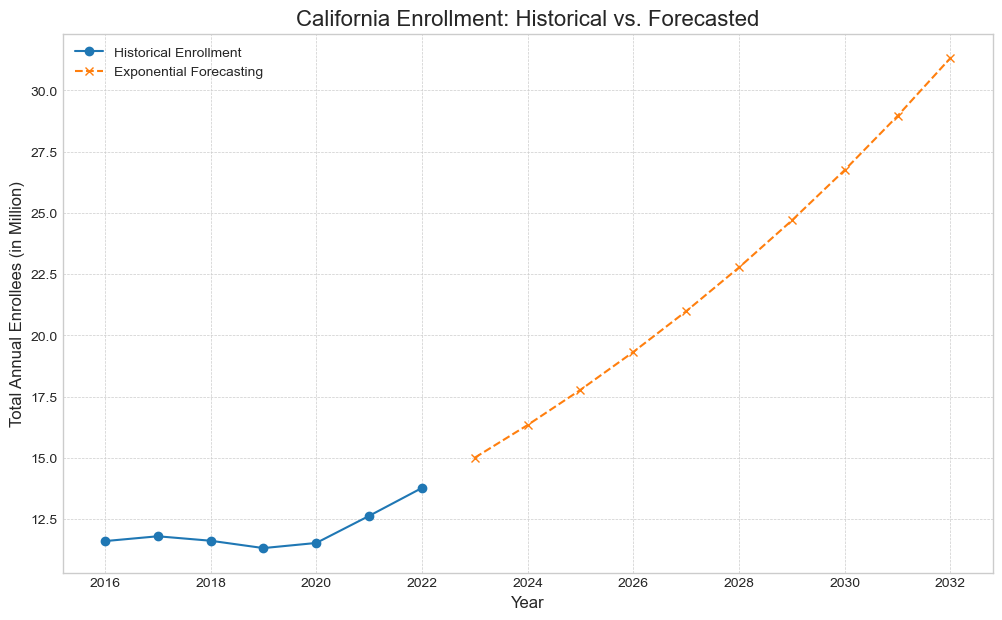

In [29]:
import pandas as pd
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt
import numpy as np


# --- 2. Corrected Visualization Code ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Plot historical data
plt.plot(Cali_enrollment_series.index, Cali_enrollment_series.values / 1_000_000, marker='o', label='Historical Enrollment')

# Plot forecasted data from the corrected DataFrame
plt.plot(forecast_df.index, forecast_df['Forecasted Enrollees'] / 1_000_000, marker='x', linestyle='--', label="Exponential Forecasting")

# Formatting the plot
plt.title('California Enrollment: Historical vs. Forecasted', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Annual Enrollees (in Million)', fontsize=12)
plt.legend()

# **THE FIX IS HERE:** This line now correctly uses the right variables to set the x-axis labels.
all_years = np.append(Cali_enrollment_series.index.values, forecast_df.index.values)
plt.xticks(np.arange(min(all_years), max(all_years) + 1, step=2))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [32]:
ustotal_df = pd.read_excel('total_US_enrollment.xlsx')
ustotal_df.head()

,Year,U.S. Enrollment(millions)
0,1973,17.6
1,1974,19.0
2,1975,20.2
3,1976,20.7
4,1977,20.7


In [38]:
from prophet import Prophet
# Prepare the DataFrame for the National Total enrollment
df_us = ustotal_df[['Year ', 'U.S. Enrollment(millions)']].rename(
    columns={'Year ': 'ds', 'U.S. Enrollment(millions)': 'y'})

df_us['ds'] = pd.to_datetime(df_us['ds'], format='%Y')

model_us = Prophet()
model_us.fit(df_us)
future_us = model_us.make_future_dataframe(periods=10, freq='Y') # Forecast 5 years
forecast_us = model_us.predict(future_us)

22:31:59 - cmdstanpy - INFO - Chain [1] start processing
22:31:59 - cmdstanpy - INFO - Chain [1] done processing


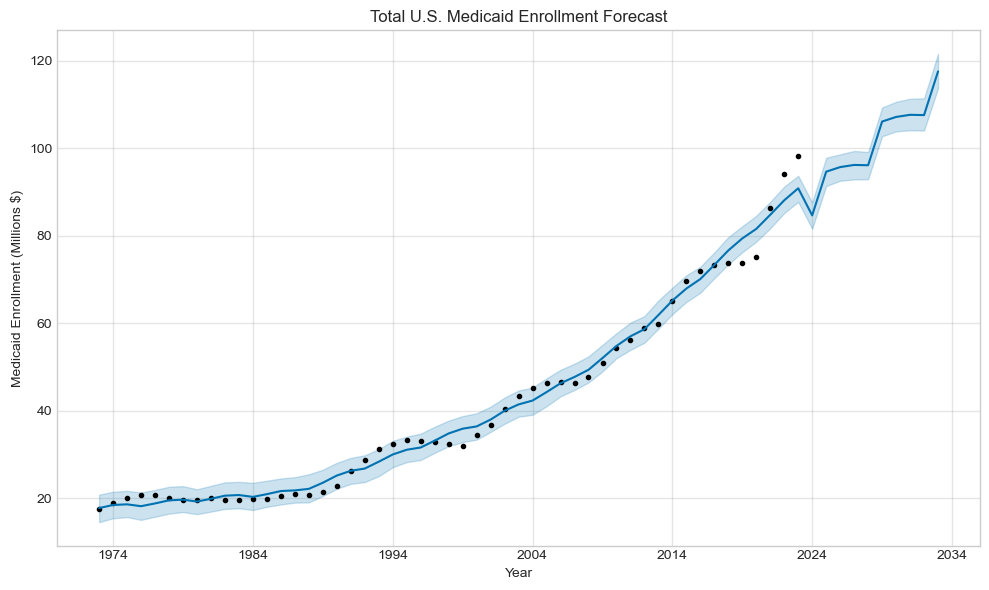

In [ ]:
# Create the U.S. plot
fig_us = model_us.plot(forecast_us)
ax_us = fig_us.gca()

# Customize labels and title
ax_us.set_xlabel("Year")
ax_us.set_ylabel("Medicaid Enrollment (Millions)")
ax_us.set_title("Total U.S. Medicaid Enrollment Forecast")

fig_us.tight_layout() # Adjust plot to prevent labels from overlapping
